In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots

In [ ]:

import scipy
from datetime import timedelta
from pylab import rcParams


from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
#from fbprophet import Prophet
!pip install pmdarima
from pmdarima import auto_arima

from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow import keras

from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import r2_score
import re

In [3]:
df = pd.read_csv('https://tinyurl.com/tsa-df')
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
def plot_ts(df, site, var, diff=False):
    if diff:
        var = var+'_diff'
    temp = df[df['Site'] == site].reset_index(drop=True)
    plt.figure(figsize=(20, 6))
    plt.plot(temp['Date'], temp[var])
    plt.title(f'{var} at {site}')
    plt.xticks(ticks=temp['Date'][temp['Date'].dt.is_month_start],
            labels=temp['Date'][temp['Date'].dt.is_month_start].dt.strftime('%m/%y'))

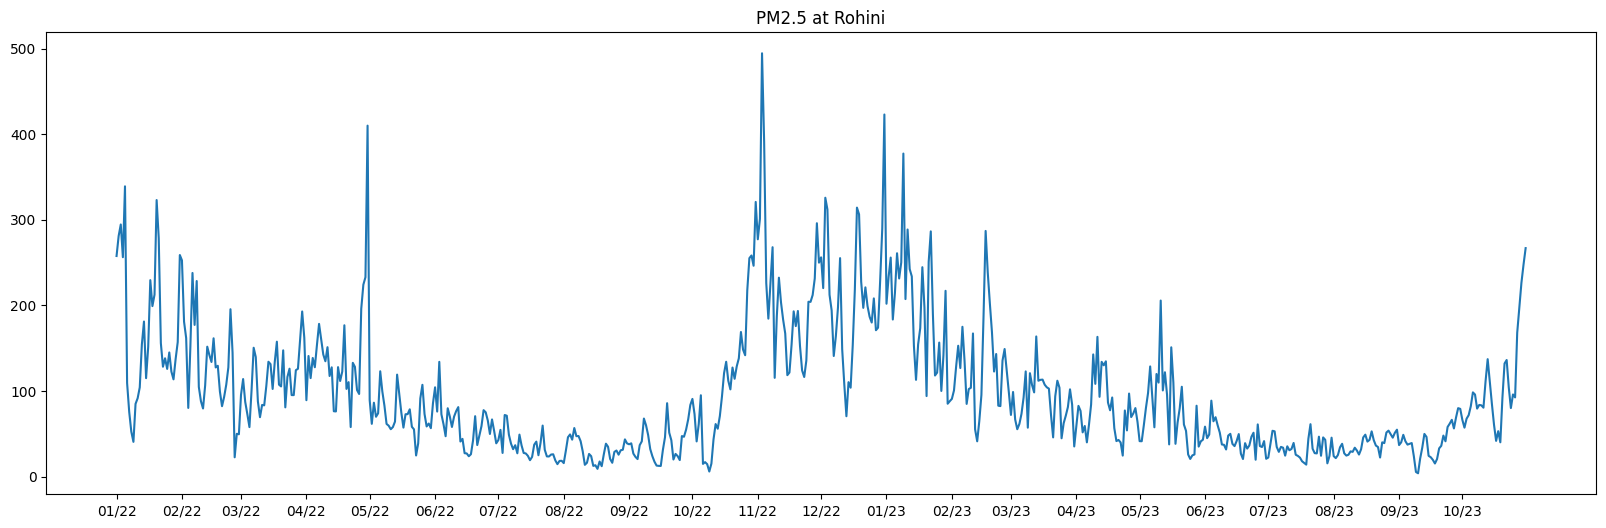

In [5]:
plot_ts(df, 'Rohini', 'PM2.5')

In [6]:
def test_stationarity(site, var, verbose=0):
    temp = df[df['Site'] == site].reset_index(drop=True)
    test = adfuller(temp[var])
    test_stat = round(test[0],3)
    pval = round(test[1],3)
    if pval < 0.05:
        if verbose == 1:
            print(f'{var} at {site} is stationary with p-value {pval} and test statistic {test_stat}')
        return 0, temp
    else:
        if verbose == 1:
            print(f'{var} at {site} is not stationary with p-value {pval} and test statistic {test_stat}')
            print('Differencing...')
        diff = temp[var].diff().dropna()
        test = adfuller(diff)
        test_stat = round(test[0],3)
        pval = round(test[1],3)
        if pval < 0.05:
            if verbose == 1:
                print(f'{var} at {site} is stationary with p-value {pval} and test statistic {test_stat}')
            temp_diff = temp[var].diff().dropna().to_frame(name=var+'_diff')
            temp = temp.join(temp_diff, how='left')
            return 1, temp
        else:
            if verbose == 1:
                print('Data is not stationary after differencing')      
            return

In [7]:
def plot_cf(df, var, type, lags = 30, diff=False):
    site = df['Site'].unique()[0]
    df = df.dropna().reset_index(drop=True)
    if diff:
        var = var+'_diff'
    if type == 'pacf':
        fig = tsaplots.plot_pacf(df[var], lags=lags)
        plt.title(f'PACF of {var} at {site}')
        fig.figure.set_size_inches(20, 6)
    
    if type == 'acf':
        fig = tsaplots.plot_acf(df[var], lags=lags)
        plt.title(f'ACF of {var} at {site}')
        fig.figure.set_size_inches(20, 6)

In [8]:
for site in df['Site'].unique():
    print(site, end=': ')
    st = []
    for var in ['PM2.5', 'PM10', 'NH3', 'SO2', 'AQI']:
        st.append(test_stationarity(site, var, verbose=0)[0])
    print(st)

Alipur: [0, 0, 0, 1, 0]
Anand Vihar: [0, 0, 0, 0, 0]
Ashok Vihar: [0, 0, 0, 1, 0]
Baghpat: [0, 0, 0, 0, 0]
Bahadurgarh: [0, 1, 0, 0, 0]
Ballabhgarh: [0, 0, 0, 1, 0]
Bawana: [1, 0, 0, 1, 1]
Dr. Karni Singh Shooting Range: [1, 1, 1, 1, 1]
Dwarka Sector-8: [1, 1, 0, 0, 0]
IMT Manesar: [0, 0, 1, 0, 0]
ITO: [0, 1, 0, 0, 1]
Indirapuram: [1, 0, 0, 0, 0]
Jahangirpuri: [1, 0, 0, 0, 0]
Jawaharlal Nehru Stadium: [1, 1, 0, 0, 0]
Knowledge Park III: [0, 0, 0, 1, 0]
Knowledge Park V: [1, 1, 1, 1, 1]
Loni: [1, 0, 0, 0, 0]
Major Dhyan Chand National Stadium: [1, 1, 0, 0, 0]
Mandir Marg: [1, 1, 1, 0, 0]
Mundka: [1, 0, 0, 0, 0]
Murthal: [1, 0, 0, 1, 0]
Najafgarh: [1, 0, 0, 0, 0]
Narela: [1, 0, 0, 1, 0]
Nehru Nagar: [1, 1, 1, 1, 1]
Okhla Phase-2: [1, 0, 0, 0, 0]
Patparganj: [1, 0, 0, 0, 0]
Punjabi Bagh: [1, 0, 0, 0, 0]
Pusa: [1, 0, 1, 1, 0]
R K Puram: [1, 1, 0, 0, 0]
Rohini: [0, 0, 0, 1, 0]
Sanjay Nagar: [1, 0, 1, 0, 0]
Sector-1 Noida: [1, 0, 0, 0, 0]
Sector-11 Faridabad: [0, 0, 0, 1, 1]
Sector-116 Noida

In [9]:
def main(df, site, var, lags=30):
    diff, temp = test_stationarity(site, var, verbose=1)
    if diff:
        plot_ts(df, site, var)
        plot_ts(temp, site, var, diff=diff)
        plot_cf(temp, var, 'acf', lags=lags, diff=diff)
        plot_cf(temp, var, 'pacf', lags=lags, diff=diff)
    else:
        plot_ts(df, site, var)
        plot_cf(temp, var, 'acf', lags=lags, diff=diff)
        plot_cf(temp, var, 'pacf', lags=lags, diff=diff)

PM2.5 at Knowledge Park V is not stationary with p-value 0.276 and test statistic -2.024
Differencing...
PM2.5 at Knowledge Park V is stationary with p-value 0.0 and test statistic -13.388


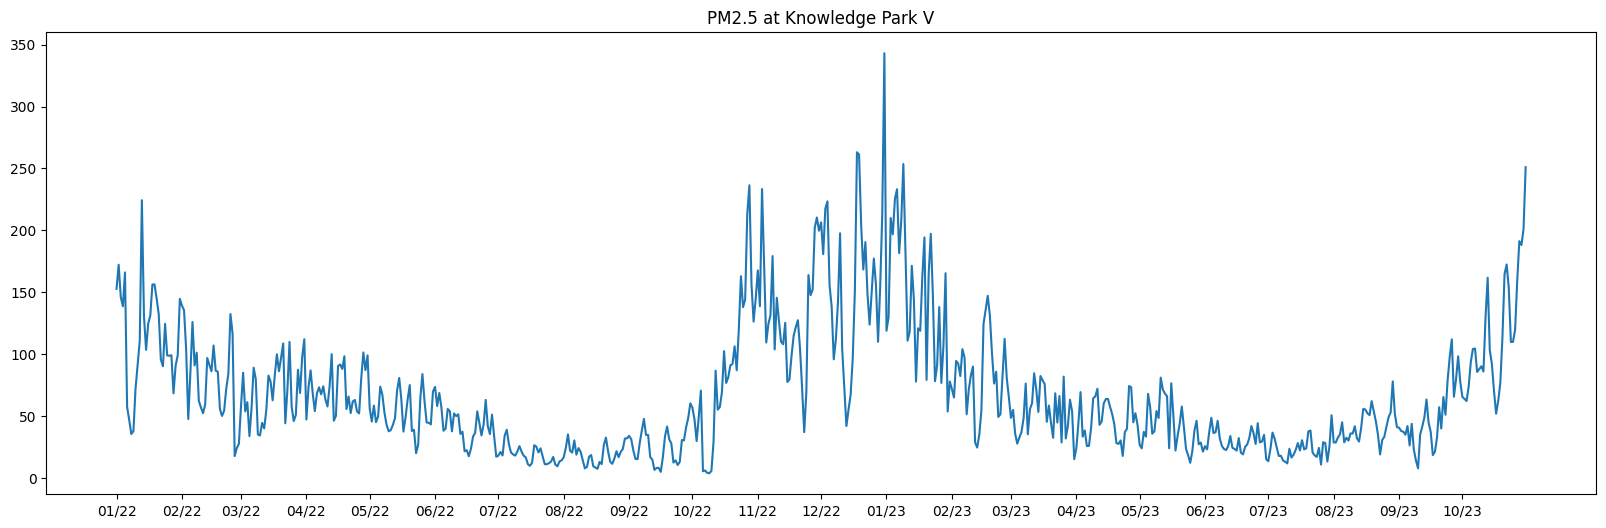

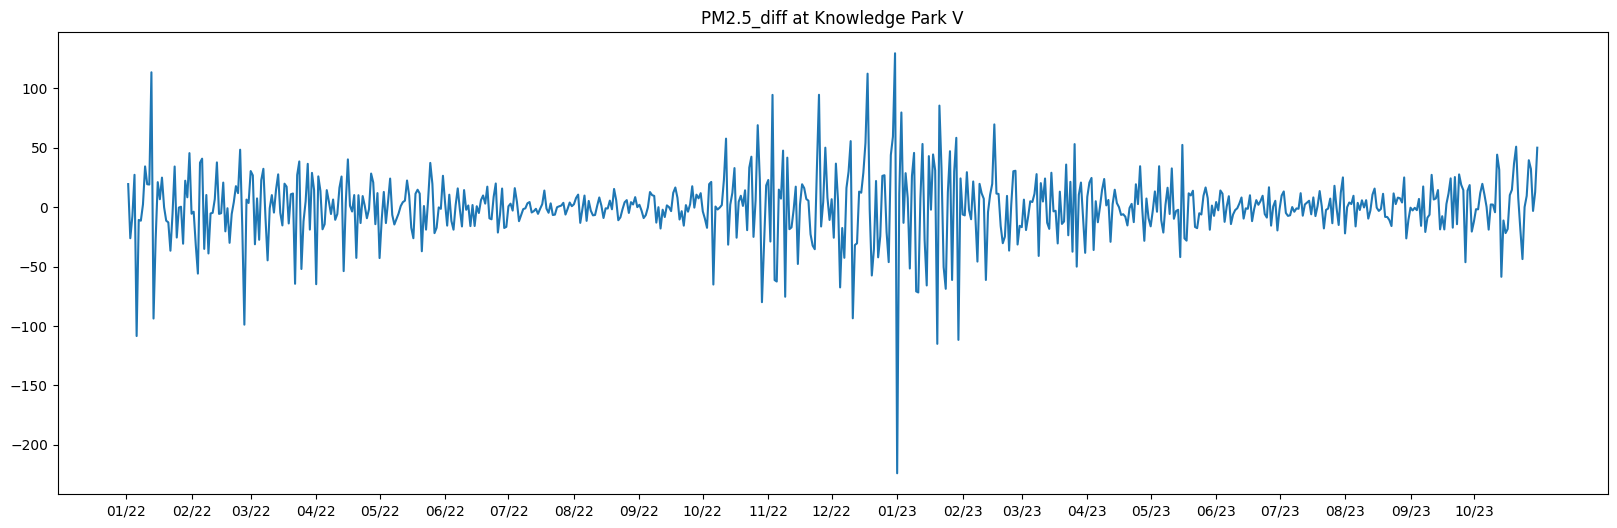

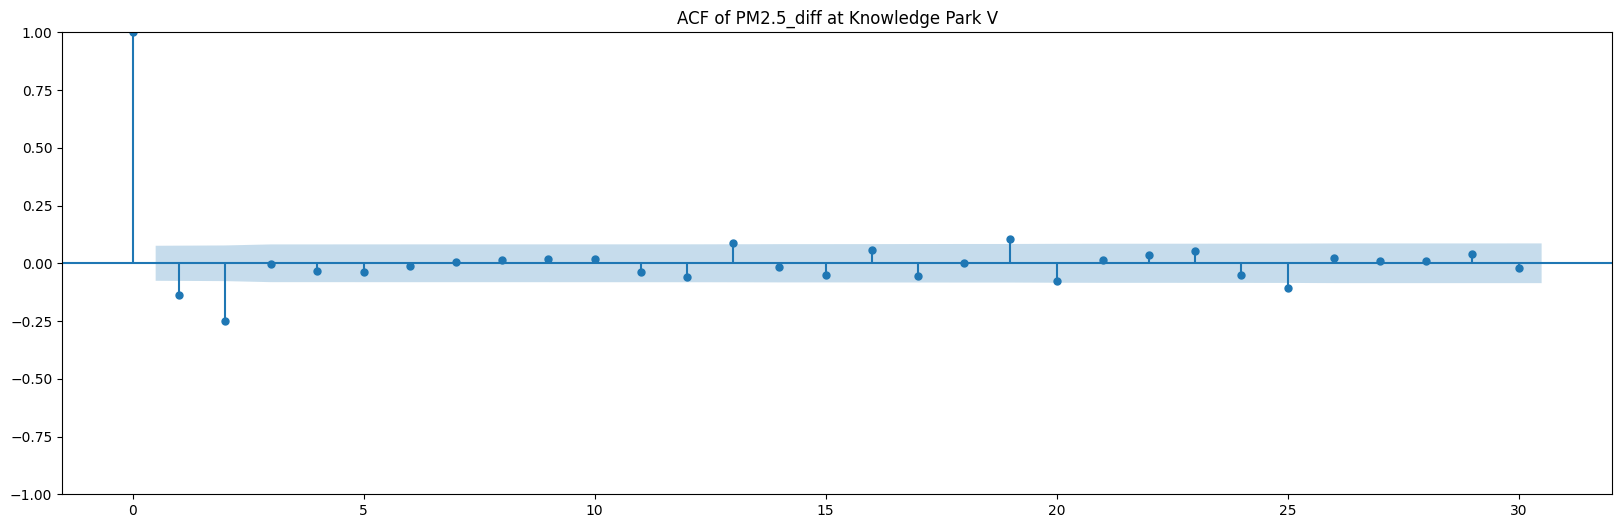

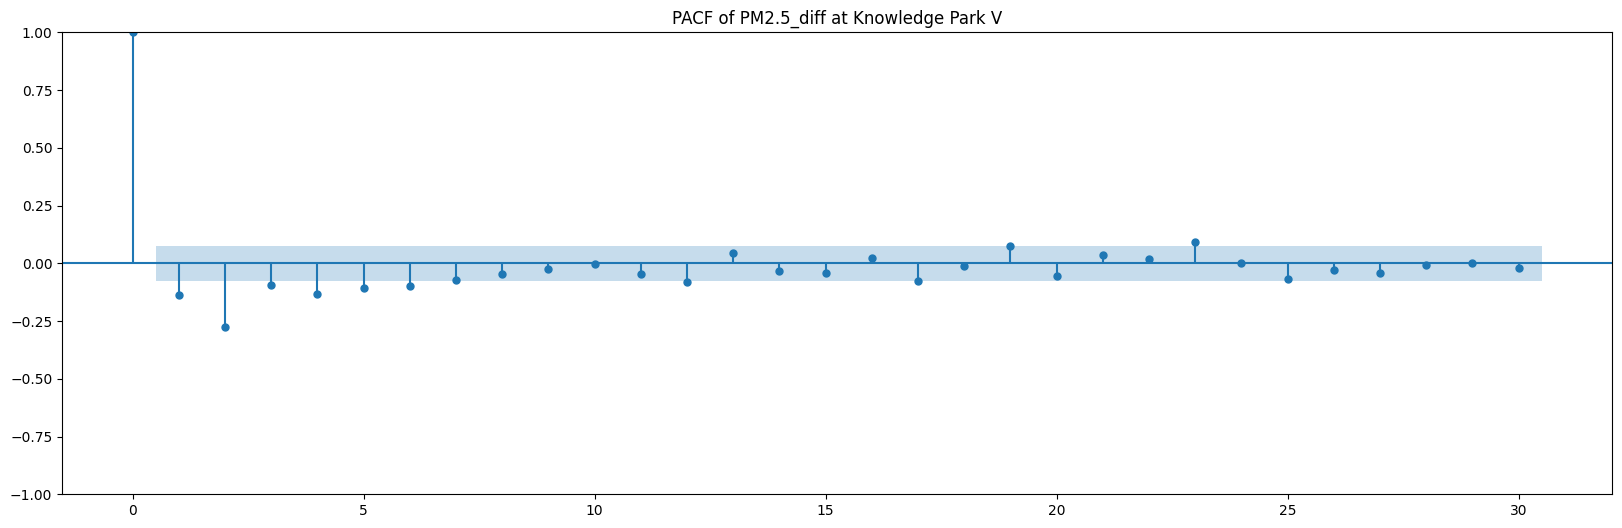

In [10]:
main(df, 'Knowledge Park V', 'PM2.5', lags=30)

SO2 at Rohini is not stationary with p-value 0.124 and test statistic -2.465
Differencing...
SO2 at Rohini is stationary with p-value 0.0 and test statistic -12.984


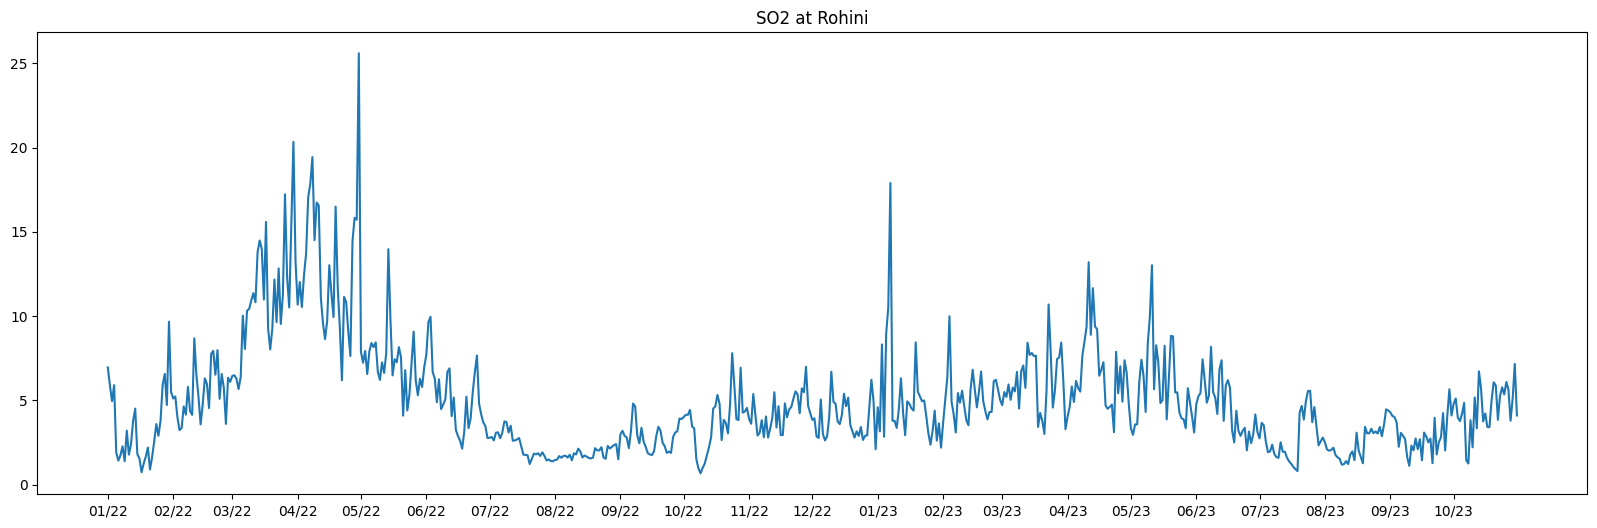

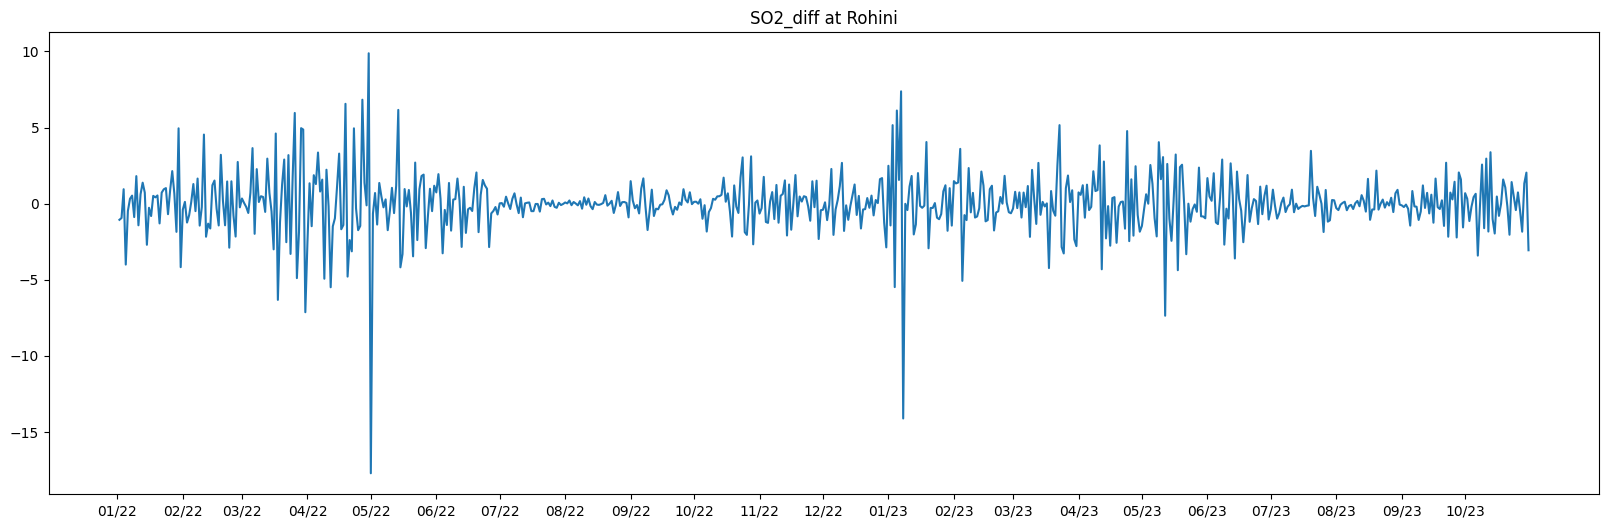

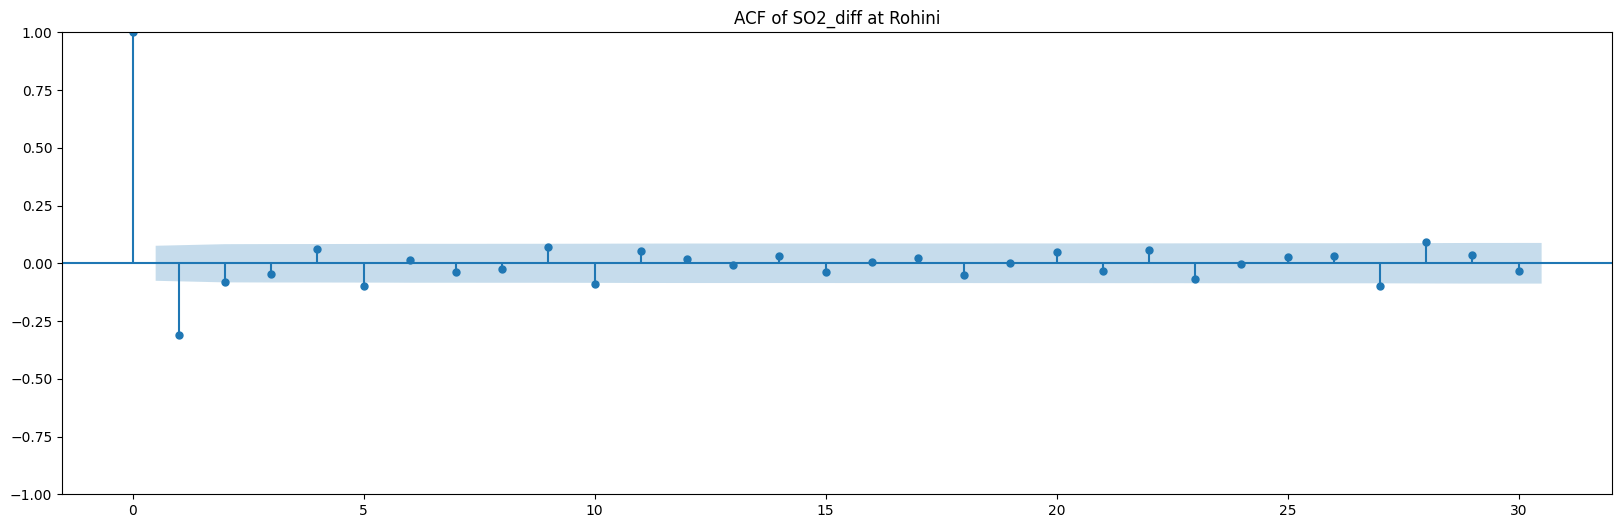

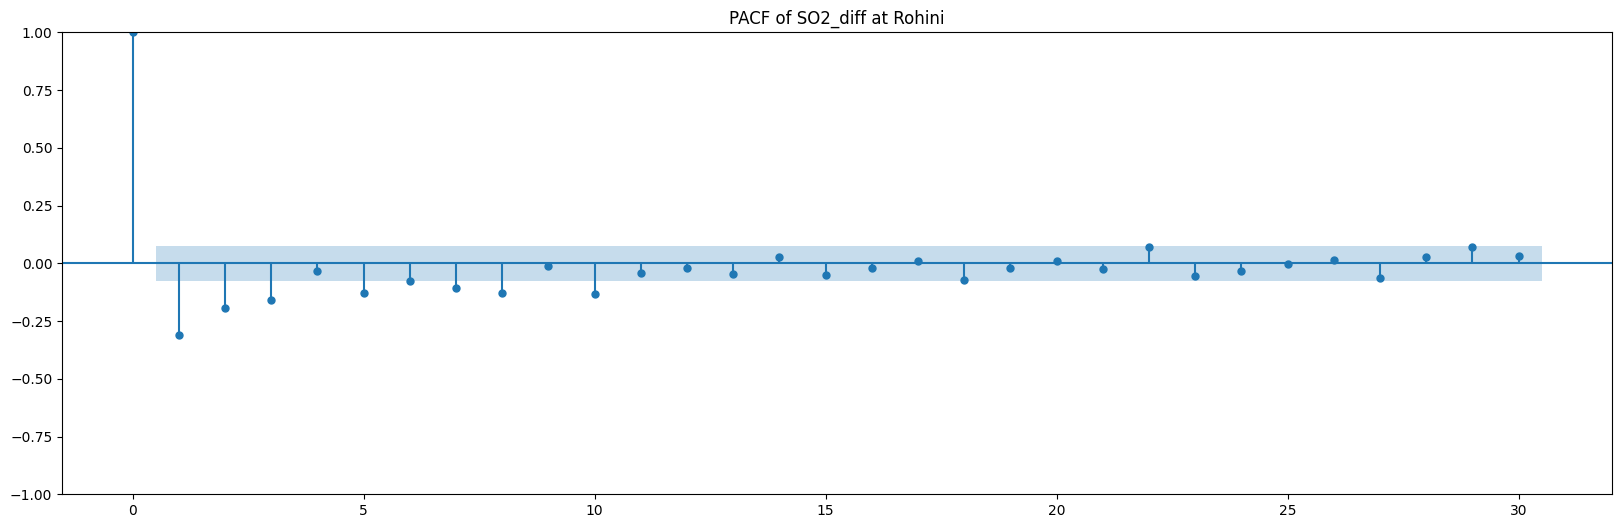

In [13]:
main(df, 'Rohini', 'SO2', lags=30)